# Forecasting demand for rental scooters using linear regression

As part of this analysis, a linear regression model was developed to predict the number of rented scooters based on time characteristics and weather conditions.

#1. Characterization of data set variables

Below is a description of all dataset variables, including the target variable:


* instant: record index
* dteday : date
* season : season (1:winter, 2:spring, 3:summer, 4:fall)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* holiday : day is holiday or not
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit :
      1: Clear, Few clouds, Partly cloudy, Partly cloudy
      2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
      3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
      4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius.
* hum: Normalized humidity.
* windspeed: Normalized wind speed.
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental scooters including both casual and registered

#2. Library loading and primary data analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
rental_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Для гитхаб/scooter Sharing Linear Regression/day.csv',delimiter=',')

In [ ]:
rental_dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Elimination of duplicate and uninformative features:**

* The instant column is just a unique identifier and does not carry any useful information for demand analysis.

* The dteday column was excluded because its information is completely duplicated by other time features (yr, mnth, weekday).

* The atemp column duplicates the temp column and is highly correlated with it, so only one of them is left to avoid multicollinearity.

* The registered and casual columns contain a breakdown of the total number of rents (cnt) into two categories of users (registered and unregistered). However, the target variable (cnt) already includes the sum of these two categories, so their separate use is not required.


In [3]:
scooter_rental = rental_dataset.drop(['instant','dteday', 'casual','atemp','registered'],axis=1)

In [ ]:
scooter_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   hum         731 non-null    float64
 9   windspeed   731 non-null    float64
 10  cnt         731 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


In [ ]:
scooter_rental.shape

(731, 11)

In [ ]:
scooter_rental.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.972500,0.507463,8714.000000


In [5]:
missing = scooter_rental.isnull().sum().sort_values(ascending=False)
print(f"Omissions:\n{missing}")

Omissions:
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64


In [6]:
scooter_rental.duplicated().sum()

print("Number of duplicates:", scooter_rental.duplicated().sum())

Number of duplicates: 0


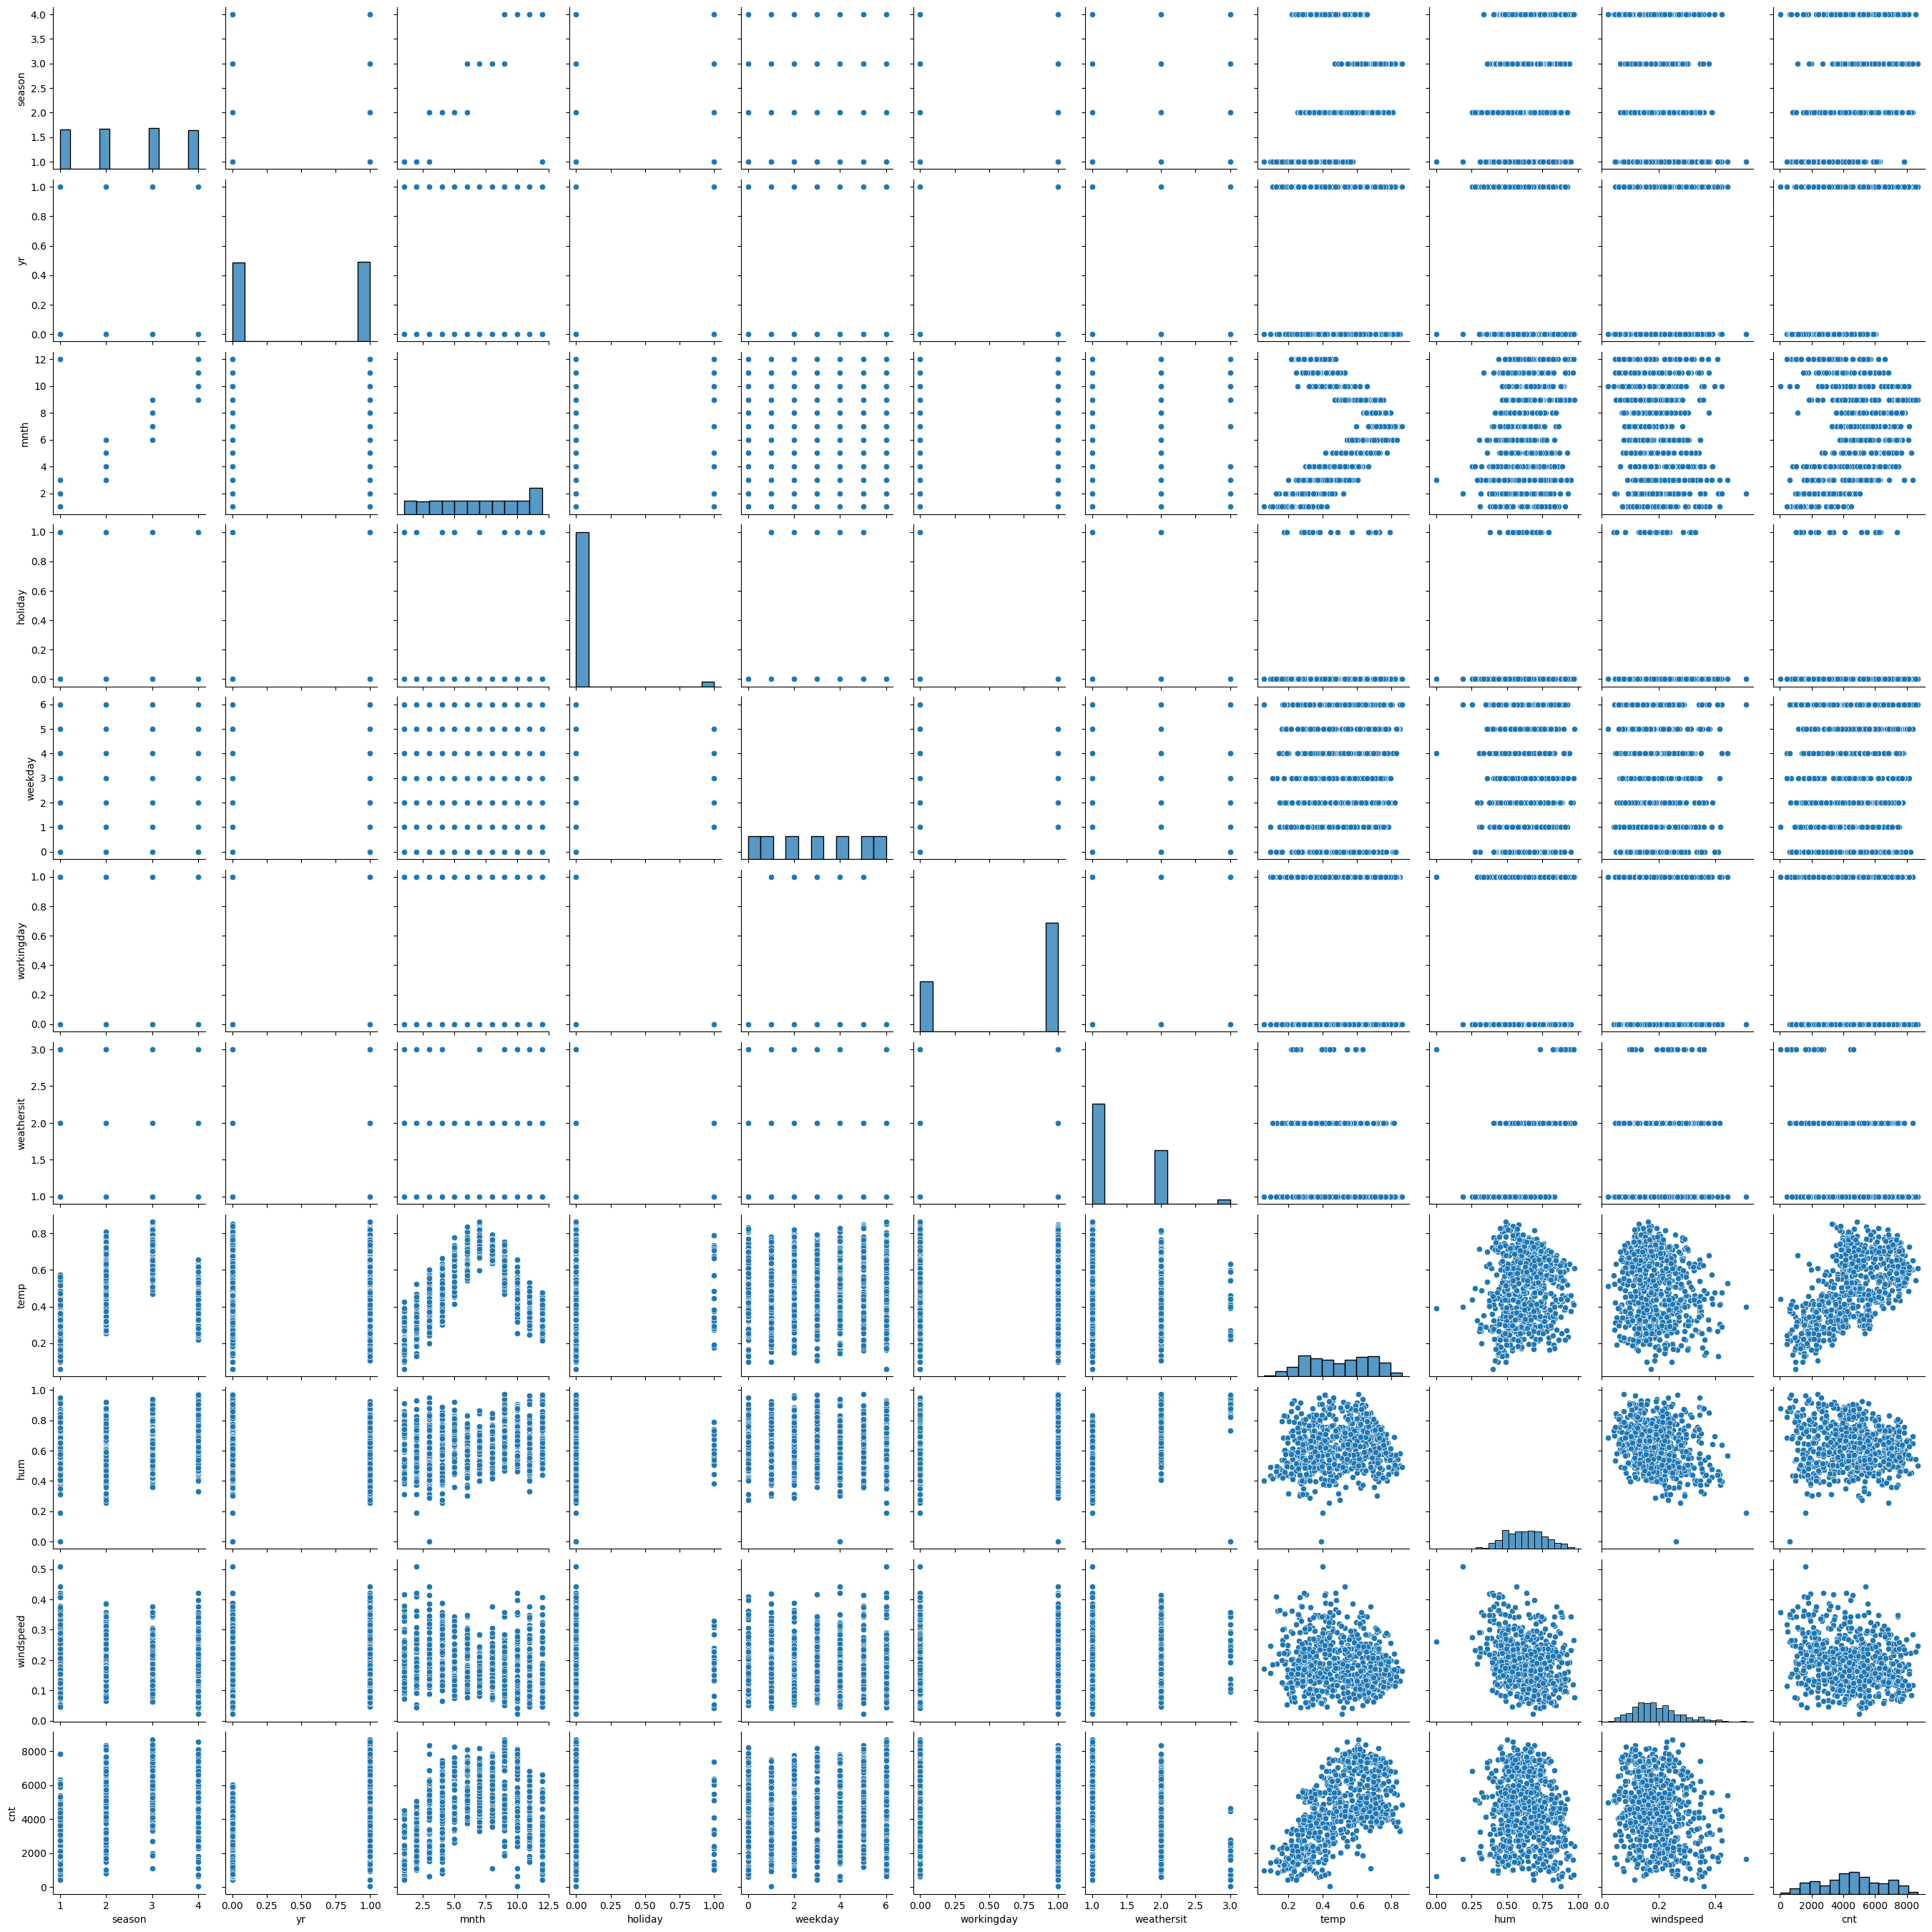

In [ ]:
sns.pairplot(scooter_rental)

The pairplot matrix shows:

* The signs season and mnth, as well as workingday and holiday, have a close relationship in meaning, since the month determines the season, and holidays are usually not working days.
* temp has a positive linear relationship with cnt, while hum and windspeed show a non-linear relationship: at extreme values, rent decreases.
* The temp distribution is bimodal, which is related to seasonal temperature fluctuations.
* The hum distribution has a left-hand asymmetry, which indicates the predominance of high humidity values.
* The windspeed distribution has a right-hand asymmetry, which means that most values are concentrated in the area of low and moderate speeds, and cases of strong winds are rare.
* In the weathersit feature, value 1 (good weather) dominates, while values 2 (cloudy weather) and 3 (rain) are less common. Value 4 (thunderstorm) is missing.
* The holiday attribute indicates that holidays are rare and their effect on the target variable may be limited.
* The workingday attribute indicates that the number of working days (value 1) significantly exceeds the number of weekends and holidays (value 0).
* The yr attribute has a balanced distribution, since both years (0 and 1) are represented in approximately equal numbers.

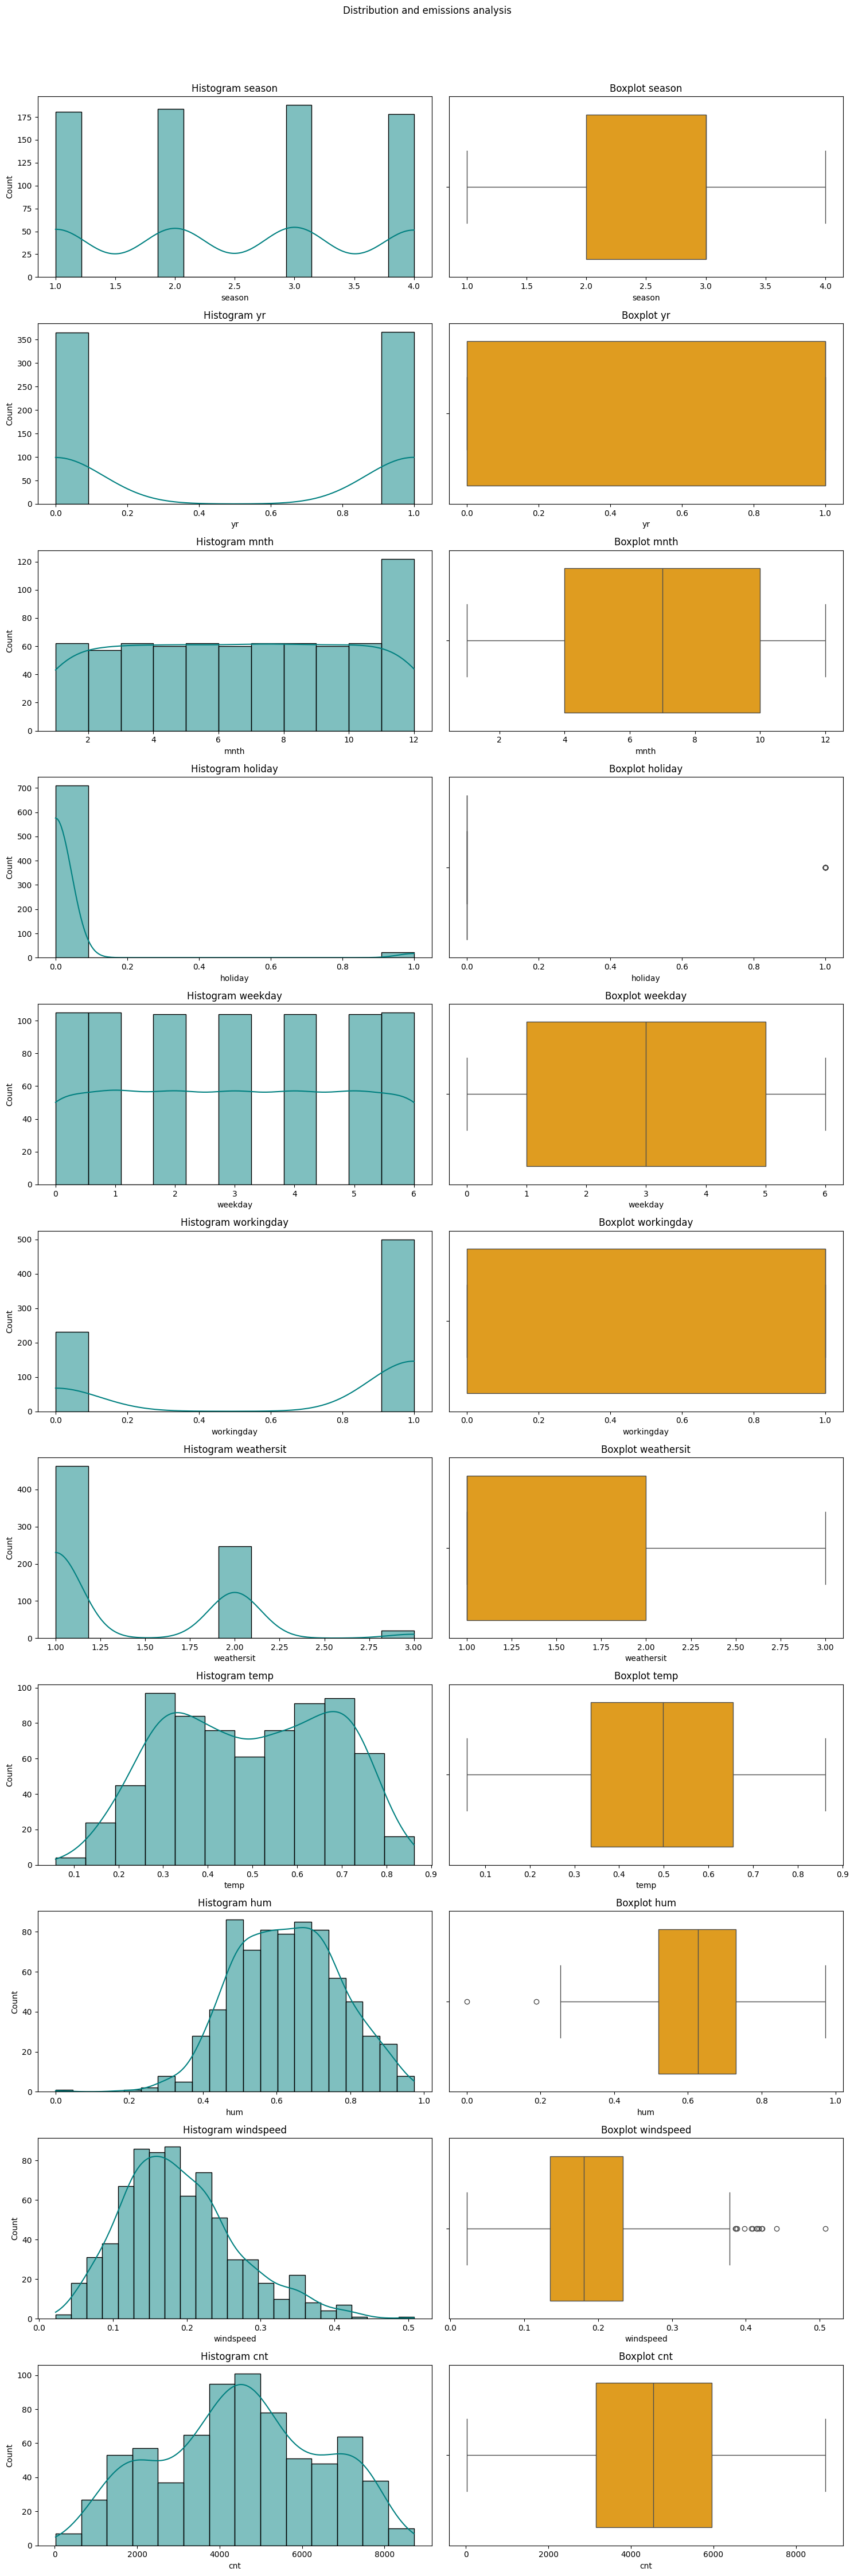

In [7]:
num_cols = scooter_rental.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2,
                        figsize=(15, 4*len(num_cols)))
fig.suptitle('Distribution and emissions analysis', y=1.02)

for i, col in enumerate(num_cols):

    sns.histplot( scooter_rental[col], kde=True, ax=axes[i, 0], color='teal')
    axes[i, 0].set_title(f'Histogram {col}')


    sns.boxplot(x= scooter_rental[col], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

Conclusions on the analysis of histograms and boxplot:

* Categorical features (season, mnth, weekday, workingday) have an approximately uniform distribution of values, with the exception of the holiday feature, where the majority of values are 0 (not holidays). Observations with a value of 1 (holidays) are rare and form small outliers in the data.

* The numerical signs (temp, hum, windspeed) are close to the normal distribution, with a moderate range of values, but windspeed contains several emissions associated with high wind speeds, which may be associated with extreme weather conditions.

* The distribution of the number of rents (cnt) has a wide range of values, with a clear tendency to accumulate data in the lower part. However, there are several emissions associated with very high values, which may indicate periods of increased demand.

In [8]:
scooter_rental.duplicated().sum()

print(f"Number of duplicates: {scooter_rental.duplicated().sum()}")

Number of duplicates: 0


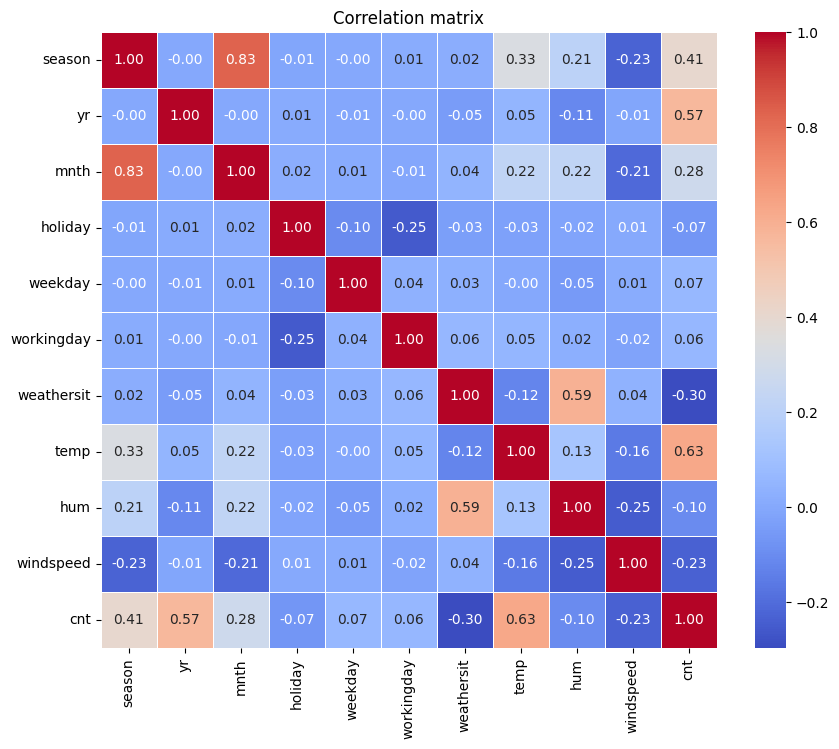

In [14]:
correlation_matrix = scooter_rental.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=0.5)

plt.title('Correlation matrix')
plt.show()

**Based on the correlation matrix, the following conclusions can be drawn:**

1. Temporary signs (season, yr, mnth, weekday, holiday, workingday):

* There is a positive correlation between cnt and season (0.41). Summer and spring may be more favorable seasons for scooter rental.

* There is a positive correlation between cnt and yr (0.57). The annual trend (yr) shows a slight increase in demand over time.

* There is a weak positive correlation between cnt and mnth (0.28). Months with more favorable weather (summer months) may have more demand.

* There is a weak positive correlation between cnt and weekday (0.07). Working days may have slightly more demand than weekends.

* There is a weak negative correlation between cnt and holiday (-0.07). Holidays may slightly reduce demand, although the impact is negligible.


* There is a weak positive correlation between cnt and workingday (0.06). Working days are associated with a slight increase in demand.



2. Weather signs (weathersit, temp, hum, windspeed):

* There is a strong positive correlation between temp and cnt (0.63). This means that as temperatures rise, the number of rented scooter (cnt) also increases.

* There is a weak negative correlation between hum and cnt (-0.10). This indicates that high humidity may reduce the demand for scooter rentals.

* There is a weak negative correlation between windspeed and cnt (-0.23). High wind speeds can also reduce the demand for bicycle rentals.

* There is a negative correlation between weathersit and cnt (-0.30).Bad weather (weathersit) can also affect demand through temperature and wind speed.

**The result of data analysis:**

* Uninformative signs have been removed

* No omissions or duplicates were found in the data

* All categorical variables are already presented in numerical format, ready for analysis

* No need to process emissions has been identified, as they reflect real patterns and events (e.g. peaks in demand, extreme weather conditions)

* All the remaining features are preserved in the model, since each of them has a theoretical basis and practical significance: time factors (season, yr, mnth, weekday, holiday, workingday) reflect the behavioral patterns of users, and weather conditions (weathersit, temp, hum, windspeed) directly affect the use of scooters. Even with weak linear correlation, these variables can contain important information about demand.
     

#3. Developing a linear regression model to predict rental demand

Methodology of training and model settings:

1. Dividing the dataset into features (x) and a target variable (y).

2. Random splitting of data into training and test samples in an 80/20 ratio with a fixed random_state for reproducibility of results.

3. Training the model using a linear regression algorithm on the prepared data.

4. Generation of forecasts for training and test samples.

5. Quality assessment using a set of metrics (MAE, RMSE, R2) for an objective assessment of model performance.


In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = scooter_rental.drop('cnt', axis=1)
y = scooter_rental['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

metrics = {
    'Training Set': {
        'MAE': mean_absolute_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R²': r2_score(y_train, y_pred_train)
    },
    'Test Set': {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R²': r2_score(y_test, y_pred_test)
    }
}

for dataset, values in metrics.items():
    print(f"\n{dataset}:")
    print(f"- MAE: {values['MAE']:.2f}")
    print(f"- RMSE: {values['RMSE']:.2f}")
    print(f"- R²: {values['R²']:.4f}")


Training Set:
- MAE: 652.83
- RMSE: 878.42
- R²: 0.7895

Test Set:
- MAE: 620.63
- RMSE: 832.78
- R²: 0.8270


#4. Evaluation and interpretation of model quality metrics

The following metrics were selected for an objective assessment of the quality of the linear regression model:


1. Coefficient of determination (R2)

* Shows how accurately the model explains variations in demand for scooters (taking into account the weather, time of day, day of the week, and holidays)

* Reflects the proportion of the explained demand variance (from 0 to 1)

2. Average Absolute Error (MAE):

* Shows the typical forecast error in real units - the number of scooters

* Resistant to rare peak days, which is important for stable planning

* Measured in the same units as the target variable (scooter rental)

3. Standard deviation (RMSE):

* Focuses on major forecasting errors due to a quadratic penalty

* Helps to identify risk situations (holidays, extreme weather conditions)


An integrated approach provides a comprehensive assessment: R2 shows the explanatory power of the model, MAE reflects day-to-day accuracy, RMSE identifies critical errors that may affect business results.

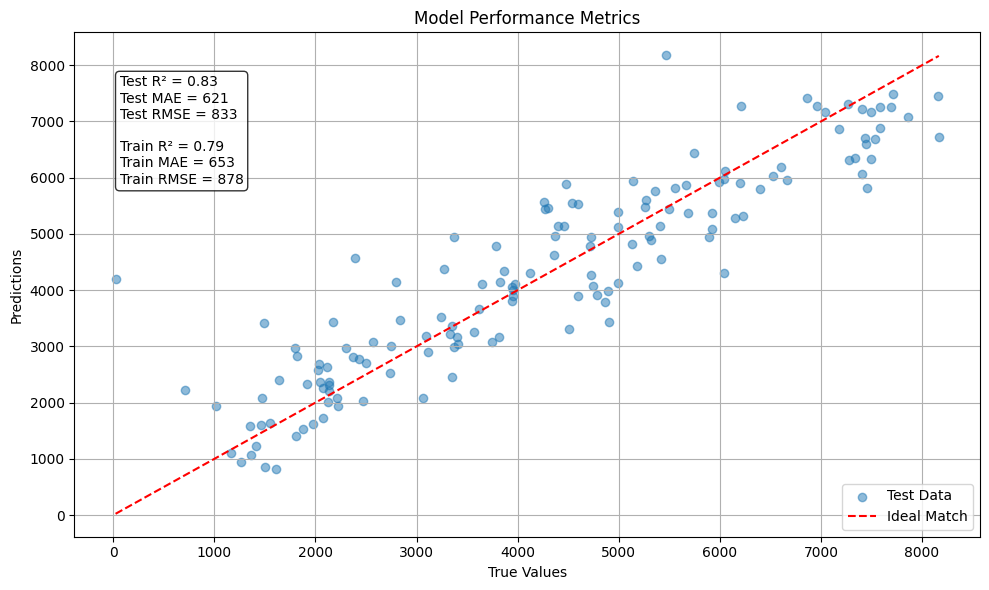

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_test, alpha=0.5, label='Test Data')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Match')

metric_text = (f"Test R² = {metrics['Test Set']['R²']:.2f}\n"
               f"Test MAE = {metrics['Test Set']['MAE']:.0f}\n"
               f"Test RMSE = {metrics['Test Set']['RMSE']:.0f}\n\n"
               f"Train R² = {metrics['Training Set']['R²']:.2f}\n"
               f"Train MAE = {metrics['Training Set']['MAE']:.0f}\n"
               f"Train RMSE = {metrics['Training Set']['RMSE']:.0f}")

plt.annotate(metric_text, xy=(0.05, 0.7), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Model Performance Metrics')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

This graph shows a comparison of true values (on the x-axis) and predicted values (on the y-axis), as well as a perfect match line (red dotted line). This visual tool allows you to evaluate how well the model matches the real data.


1. Model accuracy:


  * Coefficient of determination (R2):

      * Training sample: Train R2 = 0.79. The model explains 79% of the variation of the target variable in the training sample.

    * Test sample: Test R2 = 0.83. The model explains 83% of the variation of the target variable in the test sample.
     

Conclusion: The model has a high R2 on both the training and test samples, which indicates good prediction quality. It is especially important that the R2 on the test is higher than on the train, which indicates that the model has not been retrained.



2. Model accuracy analysis:

 * MAE = 621 is the average absolute error, which shows how wrong the model is on average in predicting demand.

 * RMSE = 833 is the root-mean-square error, which penalizes large deviations.

Errors in the context of average demand cnt = 4504 at MAE=621 and at RMSE=833 are a good result because:

* Errors in the range of 14-19% of the average — meet industry standards.

* The RMSE/MAE ratio = 833/621 ≈ 1.34 indicates a moderate amount of emissions, which is optimal for real data.


3. Risk areas:

  * The graph shows that at high values of true demand (for example, > 6000 rents), the points begin to deviate from the ideal line.

  * When demand is low (for example, < 2000 rents), the model can also produce relatively large errors. For example, if the true value is 1000 and the error is 621, that's about 62% error.


4. Withdrawal:

  * The model demonstrates the high quality of forecasts in terms of R2.

  * The MAE and RMSE values indicate fairly accurate forecasts that meet industry standards.

  * For further improvement, we can focus on optimizing predictions at peak loads and low demand, which will increase its versatility and accuracy in various scenarios.

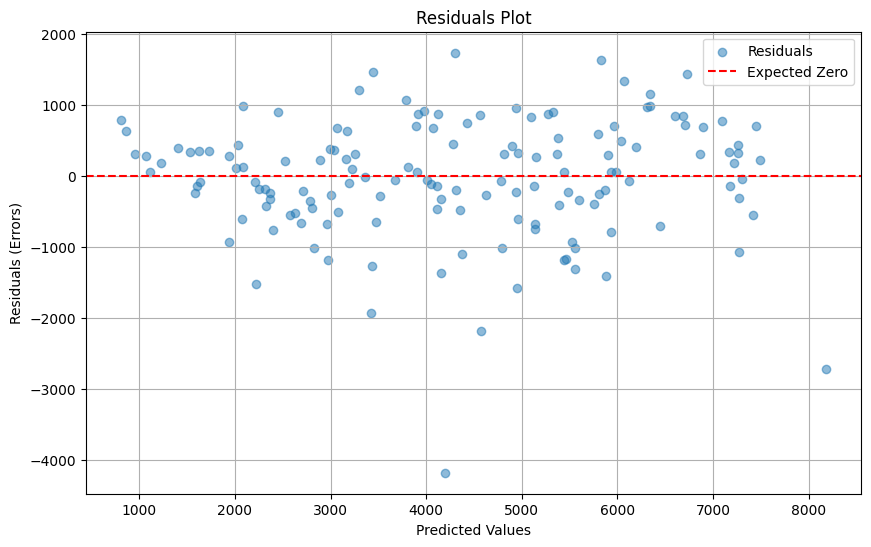

In [16]:
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5, label='Residuals')

plt.axhline(y=0, color='r', linestyle='--', label='Expected Zero')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Errors)')
plt.title('Residuals Plot')
plt.legend()
plt.grid(True)
plt.show()

This graph shows the remnants of the model: the predicted values on the horizontal axis, and the difference between the actual and predicted results (Actual — Predicted) on the vertical axis. The red dotted line indicates a line of zero residuals, which corresponds to an ideal situation where the model accurately predicts outcomes without systematic deviations.


What conclusions can be drawn:

* The model demonstrates high quality forecasts in the average demand range. However, it can be noted that with large and low demand values, larger deviations are observed.

* The results of the analysis of the residue graph indicate satisfactory compliance of the developed model with the key diagnostic criteria of linear regression.

* There are no systematic deviations in the distribution of residues, which confirms the adequacy of the model specification and the correctness of the functional form of dependence.
